In [1]:
'ADC to FFT Withbaby new approach'


'ADC to FFT Withbaby new approach'

# Loading the Data

In [2]:
import gc
gc.collect()

3

In [3]:
%reset -f

In [ ]:
label_value = 1 
label_column_name = 'Infant_Presence'

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
# Set directory containing CSV files
data_dir = r"/Users/mandarkale/Documents/MyProjects/MachineLearning/Raw/Withbaby/"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [6]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,-73,-85,-96,-108,-112,-118,-122,-126,-130,-137
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,71,72,75,75,74,73,72,60,53,50
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,61,57,51,40,31,30,24,22,14,6
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,47,55,60,62,68,72,75,75,77,75
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,64,66,72,78,79,80,80,78,83,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21015,64,32768,2,1,512,0,1953125,12,0.0,0,...,36,38,43,48,48,54,57,55,57,53
21016,64,32768,2,1,512,0,1953125,12,0.0,0,...,66,67,71,71,74,72,74,81,86,91
21017,64,32768,2,1,512,0,1953125,12,0.0,0,...,-24,-30,-33,-42,-48,-43,-39,-40,-38,-35
21018,64,32768,2,1,512,0,1953125,12,0.0,0,...,-18,-19,-21,-22,-29,-32,-35,-34,-35,-33


In [7]:
combined_df.shape

(21020, 16400)

In [8]:
adc_data = combined_df.iloc[:, 16:].values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[-143, -151, -154, ..., -126, -130, -137],
       [  48,   43,   35, ...,   60,   53,   50],
       [   0,  -11,  -18, ...,   22,   14,    6],
       ...,
       [ -35,  -31,  455, ...,  -40,  -38,  -35],
       [ -34,  -33,  -32, ...,  -34,  -35,  -33],
       [ -38,  -38,  -32, ...,  -40,  -41,  -38]], shape=(21020, 16384))

In [9]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[-132.74689627, -145.85522471, -160.06537177, ..., -117.88340709,
        -122.44036243, -126.49033501],
       [  73.44538652,  103.07026798,  131.74795661, ...,   65.30978057,
          65.15603004,   64.87030029],
       [  27.63206319,   28.35382623,   27.51109601, ...,   27.37586412,
          24.04507053,   21.00643651],
       ...,
       [   9.86718195,   63.68219463,  115.04259008, ...,  -37.16488889,
         -38.83196025,  -40.21943291],
       [   9.02658058,   59.95461375,  108.69606039, ...,  -32.65593513,
         -34.49163914,  -36.04805996],
       [  -6.80646151,   45.17728878,   95.68255806, ...,  -33.02839371,
         -35.66353542,  -37.94289152]], shape=(21020, 16384))

In [10]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 25.88 dB


In [11]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([2.24444354, 9.48600922, 6.41883804, ..., 6.13854747, 6.29873005,
       5.59572588], shape=(21020,))

# ADC to FFT Conversion

In [12]:
# Assuming `adc_data` is your pandas Series with ADC data
adc_array = adc_data_selected_columns # Convert the pandas Series to a numpy array

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Filter frequencies within 35kHz - 45kHz
#valid_indices = (freq >= min_freq) & (freq <= max_freq)
#filtered_freqs = freq[valid_indices]
#filtered_magnitudes = magnitude[valid_indices]
#filtered_phase = phase[valid_indices]

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})


fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.000000,85482.192762,2.659895e-18
1,92.917460,40258.220857,-3.125651e+00
2,185.834919,5221.175683,2.865319e+00
3,278.752379,3160.342162,-3.600372e-01
4,371.669838,110.182115,-4.779431e-01


In [ ]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
#For Withbaby vs Withoutbaby
#fft_df['Infant_Presence'] = 1 # 1 for presence, 0 for absence 
fft_df[label_column_name] = label_value
# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000000,85482.192762,2.659895e-18,1
1,92.917460,40258.220857,-3.125651e+00,1
2,185.834919,5221.175683,2.865319e+00,1
3,278.752379,3160.342162,-3.600372e-01,1
4,371.669838,110.182115,-4.779431e-01,1


In [14]:
len(fft_df)

21020

In [15]:
fft_df.tail()

,Frequency,FFT Magnitude,Phase,Infant_Presence
21015,-464.587298,862.049715,2.715918,1
21016,-371.669838,110.182115,0.477943,1
21017,-278.752379,3160.342162,0.360037,1
21018,-185.834919,5221.175683,-2.865319,1
21019,-92.917460,40258.220857,3.125651,1


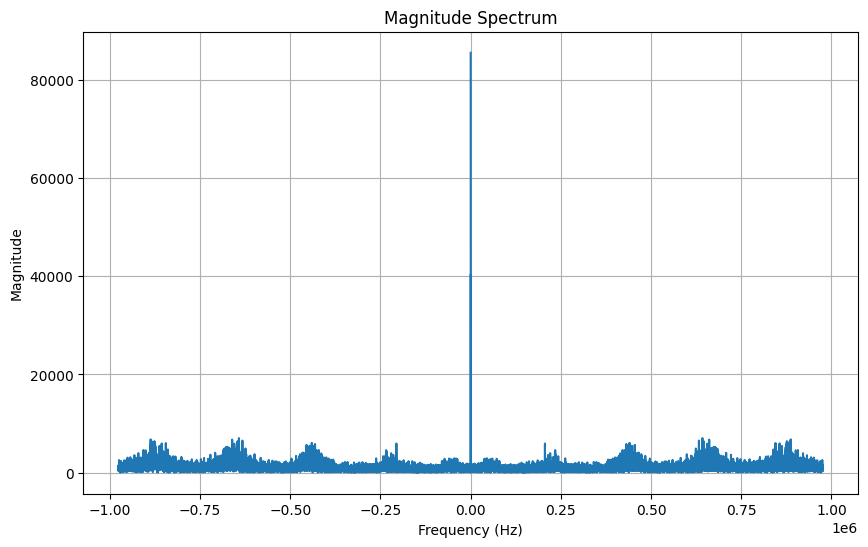

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

# Saving as Numpy Array

In [ ]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
#np.save('demo_4.npy', numpy_array)

# Define save path (2 levels up → Data/Processed/)
project_root = "/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code"
save_path = os.path.join(project_root, "Data", "Processed", "Withbaby_npy_array_Lowpassfiltered.npy")


# If file already exists, remove it
if os.path.exists(save_path):
    os.remove(save_path)
    print(f"Old file removed: {save_path}")

# Save the array to that location
np.save(save_path, numpy_array)

print(f"New file saved at: {os.path.abspath(save_path)}")


Old file removed: ../../Data/Processed/Withbaby_npy_array_Lowpassfiltered.npy
New file saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/Withbaby_npy_array_Lowpassfiltered.npy


In [18]:
import gc
gc.collect()

3311

In [19]:
%reset -f